In [2]:
# 필요한 라이브러리 설치 및 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm
import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.

import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [19]:
!pip install workalendar

  Obtaining dependency information for workalendar from https://files.pythonhosted.org/packages/4a/23/2fd9e240ae95be5653d57cc39d5377278eb376b4b3f30e27526d831b1668/workalendar-17.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for lunardate from https://files.pythonhosted.org/packages/a3/07/232401bb1c6bc699c5e641ad375e2582cdde90b19b18e6618ec51796b737/lunardate-0.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for convertdate from https://files.pythonhosted.org/packages/27/65/3deecc820ce91716225ec72b584b48ba9512ed9583ad48619e3dbbbbd714/convertdate-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyluach from https://files.pythonhosted.org/packages/4f/83/2e585d06d49e0320050b3d7d8ae0dfbd1459e976ff9f4b4d8bcca983d474/pyluach-2.2.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/5.8 MB ? eta -:--:--
     -- ------------------------------------- 0.3/5.8 MB 7.2 MB/s eta 0:00:01
     ------ ----------------------

## 1. Data Load

In [3]:
open = pd.read_csv('./open_data.csv')
weather = pd.read_csv('./weather.csv')

In [4]:
open.head(2)

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611


In [5]:
weather.head(2)

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16


In [6]:
open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


## 2. EDA

In [8]:
open.rename(columns={'기준일' : 'Date',
                     '차량운행' : 'taxi',
                     '접수건' : 'call',
                     '탑승건' : 'board',
                     '평균대기시간' : 'wait_time',
                     '평균요금' : 'fare',
                     '평균승차거리' : 'dist'}, inplace=True)

In [9]:
weather['Date'] = pd.to_datetime(weather['Date'])
open['Date'] = pd.to_datetime(open['Date'])

In [10]:
# 날씨 데이터를 택시운행 데이터와 맞추기 위해 하루전으로 수정
weather['Date'] = weather['Date'].apply(lambda x : x - pd.Timedelta(days=1))

In [11]:
df = pd.merge(open, weather, how='inner', on='Date')

In [12]:
# target 생성
df['target'] = df['wait_time'].shift(1)

In [13]:
# 날짜 변수 생성
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.day_of_week
df['season'] = np.where(df['month'].isin([3,4,5]), 'Spring',
                           np.where(df['month'].isin([6,7,8]), 'Summer',
                                    np.where(df['month'].isin([9,10,11]), 'Fall', 'Winter')))
df['season'] = pd.Categorical(df['season'], categories=['Spring','Summer','Fall','Winter'])

In [20]:
from workalendar.asia import SouthKorea

cal = SouthKorea()
holiday = pd.DataFrame()
for y in range(2015, 2023) :
    holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

holiday.columns = ['Date', 'holiday']
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['holiday'] = 1
holiday.head(3)

,Date,holiday
0,2015-01-01,1
1,2015-02-18,1
2,2015-02-19,1


In [21]:
# holiday : 해당일 휴일 여부 / next_holiday : 다음날 휴일 여부
df = pd.merge(df, holiday, how = 'left')
df.loc[df['weekday'].isin([5, 6]), 'holiday'] = 1
df = df.fillna({'holiday':0})
df['next_holiday'] = df['holiday'].shift(-1)

In [22]:
# 파생변수 생성
df['waiting_avg7'] = df['wait_time'].rolling(7).mean()
df['waiting_avg3'] = df['wait_time'].rolling(3).mean()
df['cancel'] = df['call'] - df['board']
df['temp_diff'] = df['temp_max'] - df['temp_min']
df['humidity_diff'] = df['humidity_max(%)'] - df['humidity_min(%)']
df['board_rate'] = df['board'] / df['call']
df['call_rate'] = df['call'] / df['taxi']
df['unit_charge'] = df['fare'] / df['dist']
df['board_taxi_rate'] = df['board'] / df['taxi']

In [23]:
dummies_cols = ['season']

In [24]:
df = pd.get_dummies(df, columns=dummies_cols, dtype=int)

<Axes: ylabel='taxi'>

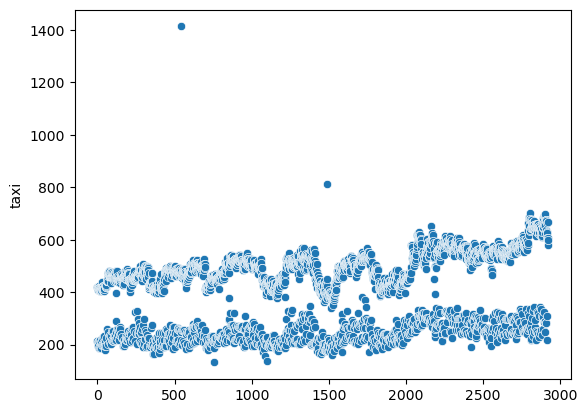

In [25]:
sns.scatterplot(df['taxi'])

In [26]:
# 이상치 처리
df.drop(df[df['taxi'] > 800].index, inplace=True)

In [27]:
df.dropna(inplace=True)

In [28]:
train = df[df['Date'] < '2022-10-01']
test = df[df['Date'] > '2022-09-30']

## 3. Modeling

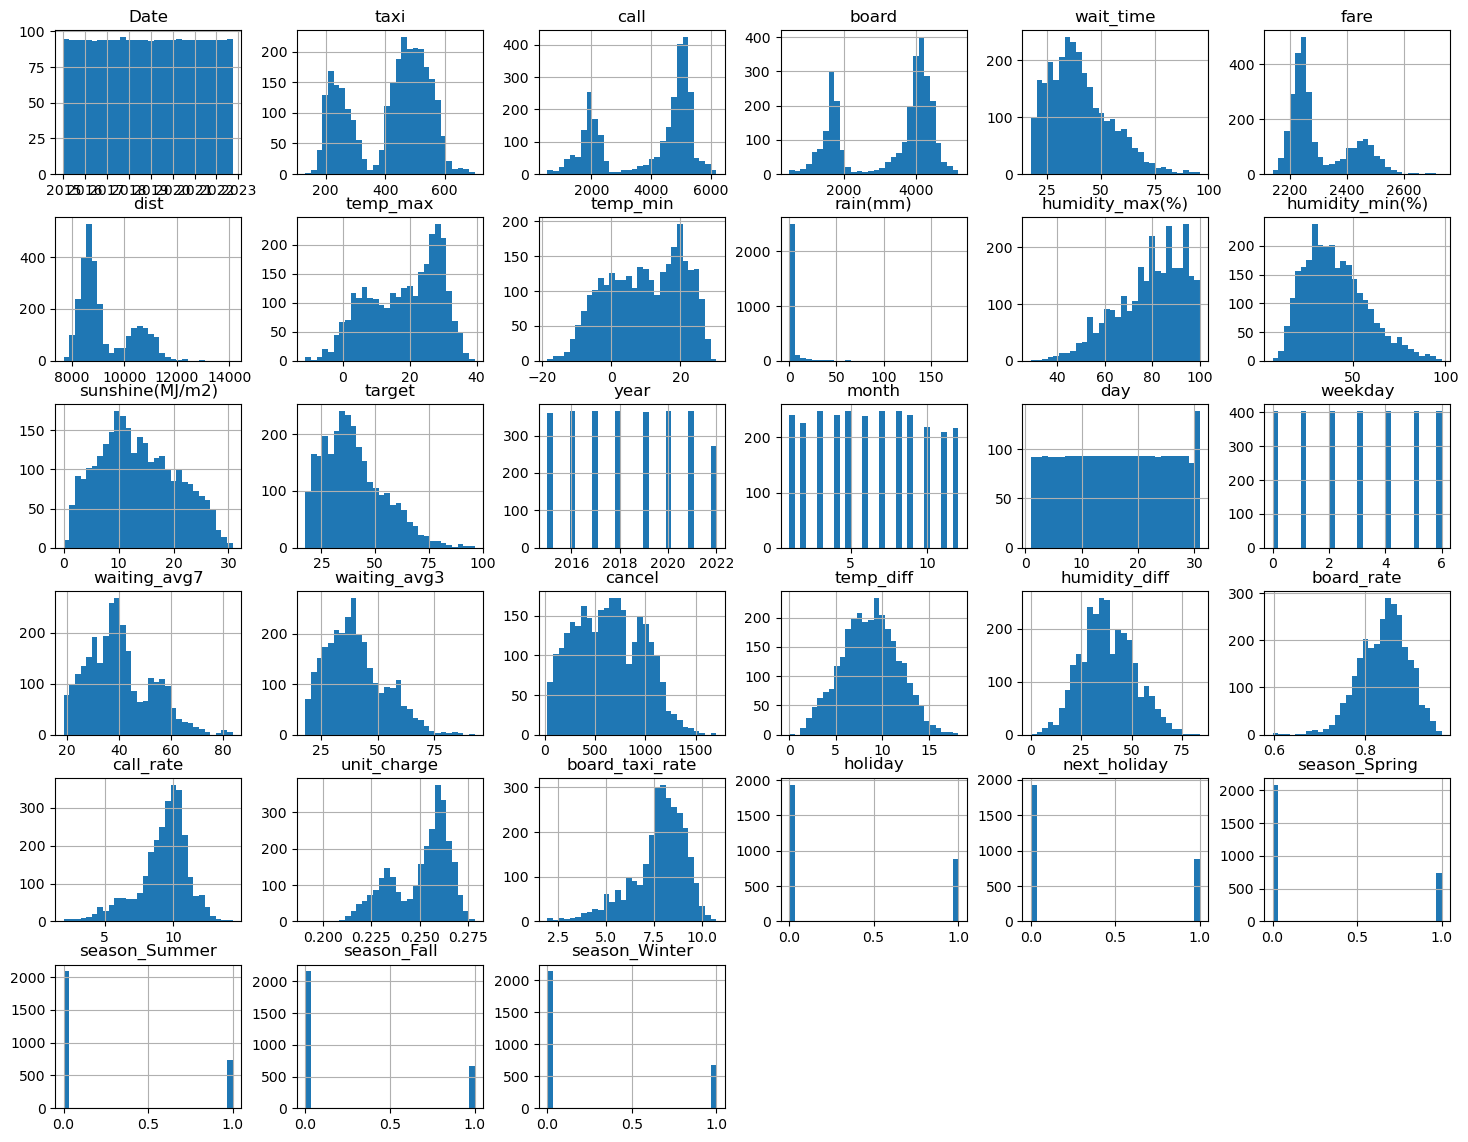

In [29]:
train.hist(bins=30, figsize=(18, 14))
plt.show()

In [30]:
target_log = ['fare', 'dist', 'target', 'waiting_avg7', 'waiting_avg3', 'wait_time', 'rain(mm)']

In [31]:
log_train = train.copy()
log_test = test.copy()

In [32]:
log_train[target_log] = np.log1p(log_train[target_log])
log_test[target_log] = np.log1p(log_test[target_log])

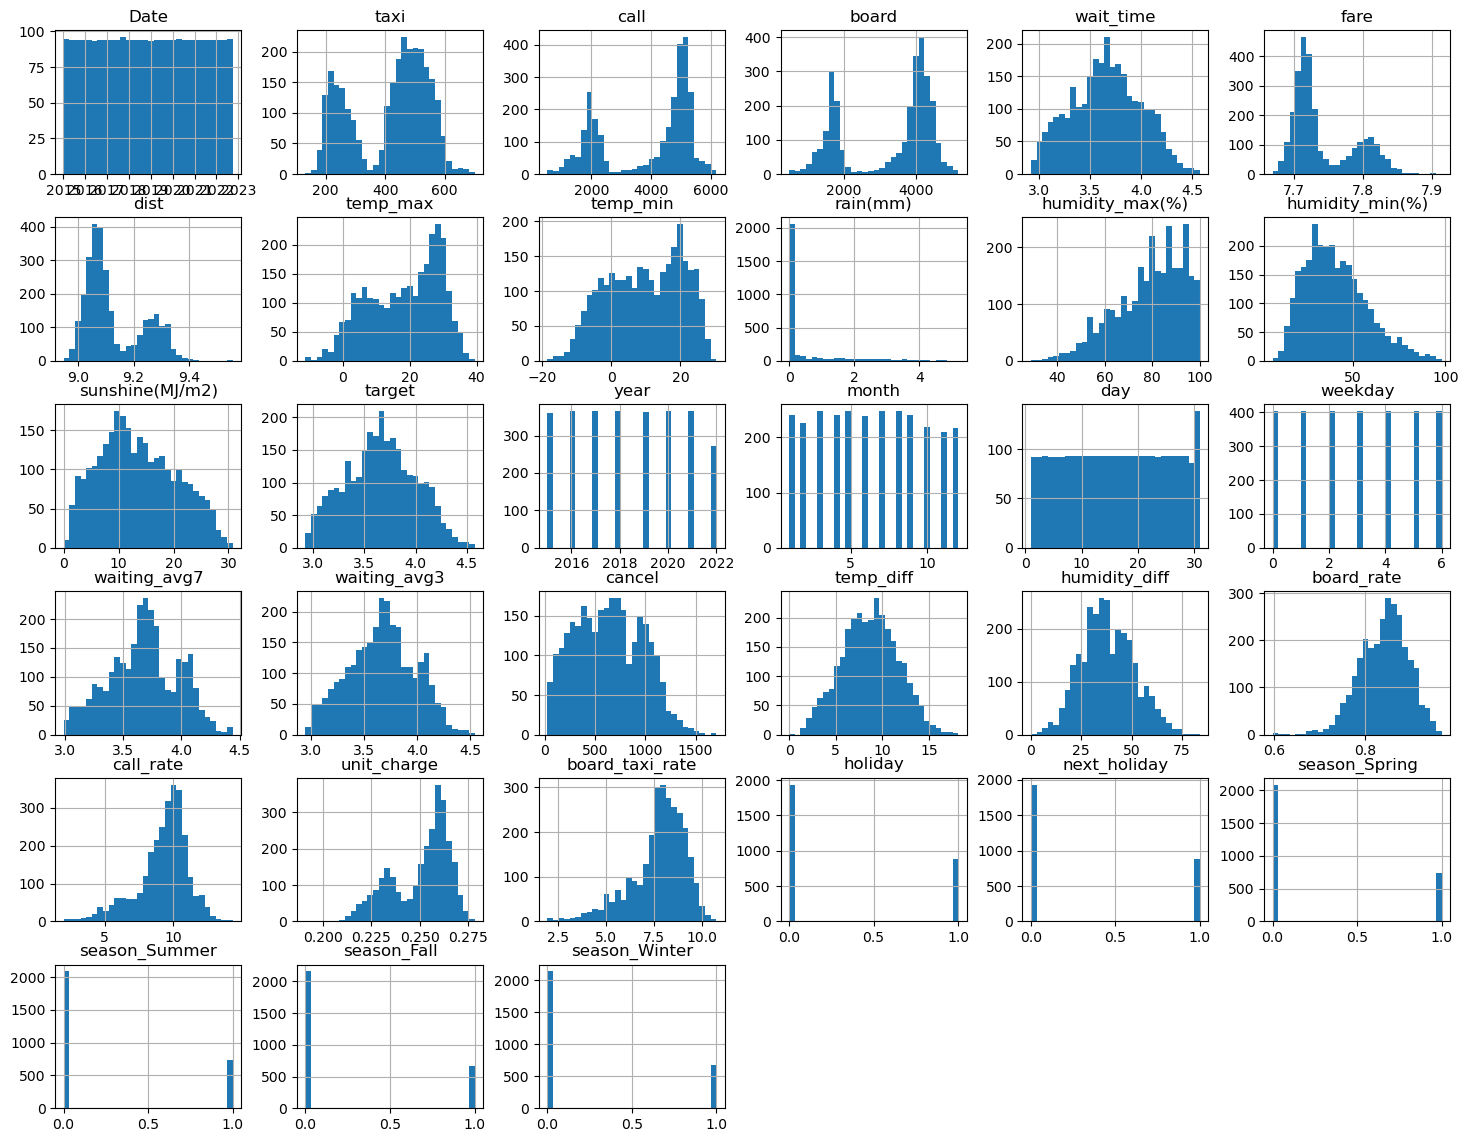

In [33]:
log_train.hist(bins=30, figsize=(18, 14))
plt.show()

In [34]:
target = 'target'
train_x = train.drop([target, 'Date'], axis=1)
train_y = train.loc[:, target]

test_x = test.drop([target, 'Date'], axis=1)
test_y = test.loc[:, target]

In [35]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2823, 31), (2823,), (90, 31), (90,))

In [36]:
target = 'target'
log_train_x = log_train.drop([target, 'Date'], axis=1)
log_train_y = log_train.loc[:, target]

log_test_x = log_test.drop([target, 'Date'], axis=1)
log_test_y = log_test.loc[:, target]

In [37]:
log_train_x.shape, log_train_y.shape, log_test_x.shape, log_test_y.shape

((2823, 31), (2823,), (90, 31), (90,))

In [38]:
# 모델별 파라미터 정의
lgb_params = {
    'metric': 'mean_absolute_percentage_error',
    'random_state': 42
}

xgb_optuna = {
    'metric' : 'mean_absolute_percentage_error',
    'random_state': 42
}

cat_params = {
    'eval_metric': 'MAPE',
}

random_params = {
    'criterion' : 'absolute_error'
}

decision_params = {
    "criterion":'absolute_error',  
    "random_state":42,
}

gbr_params = {
    "criterion" : 'friedman_mse'
    
}
linear_params = {
    "n_jobs" : -1
}
sgd_params = {
    'penalty' : 'l2',
    'early_stopping' : True
}

In [39]:
# 모델 선언
models = {
    'LGBM': LGBMRegressor(**lgb_params),
    'XGB': XGBRegressor(**xgb_optuna), 
    'Cat': CatBoostRegressor(**cat_params),
    'RF': RandomForestRegressor(**random_params),
    'Hist':HistGradientBoostingRegressor(),
    'Decision':DecisionTreeRegressor(**decision_params),
    'GBR':GradientBoostingRegressor(**gbr_params),
    'KNN':KNeighborsRegressor(),
    'linear' : LinearRegression(),
    'SVR' : SVR(kernel='linear')
}

NameError: name 'CatBoostRegressor' is not defined

In [40]:
def plot_pred(y_test, y_pred, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 2823, number of used features: 31
[LightGBM] [Info] Start training from score 40.228587


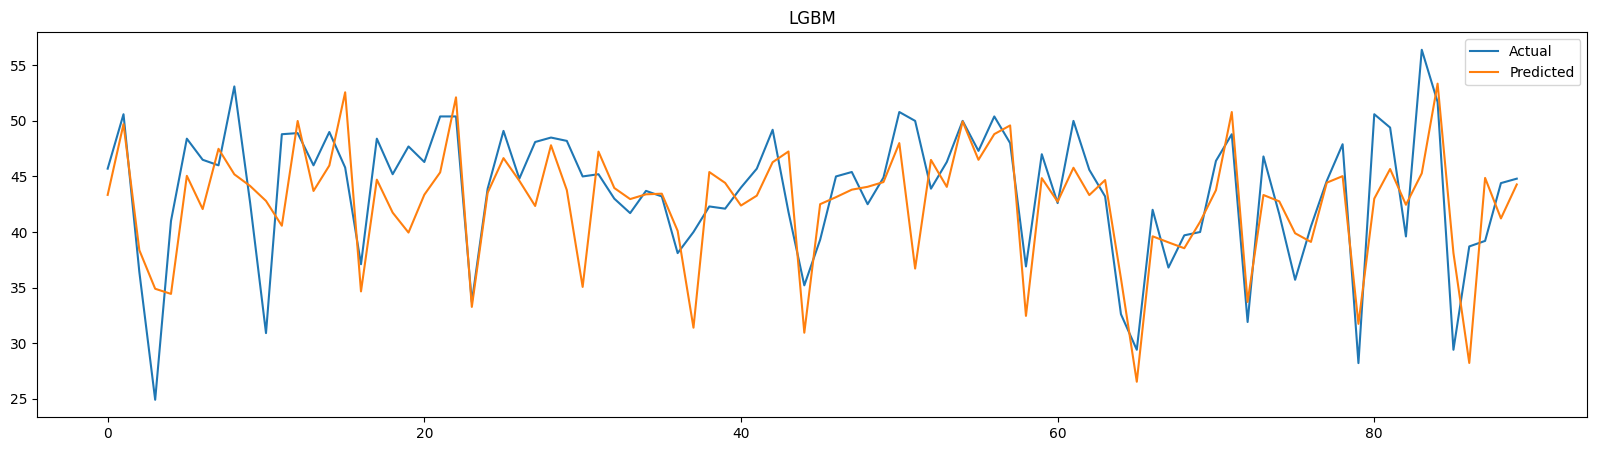

LGBM   RMSE :  4.445135518598336
LGBM   MAPE :  0.08054587978643993
LGBM   MAE :  3.36088480297723
[14:20:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "metric" } are not used.



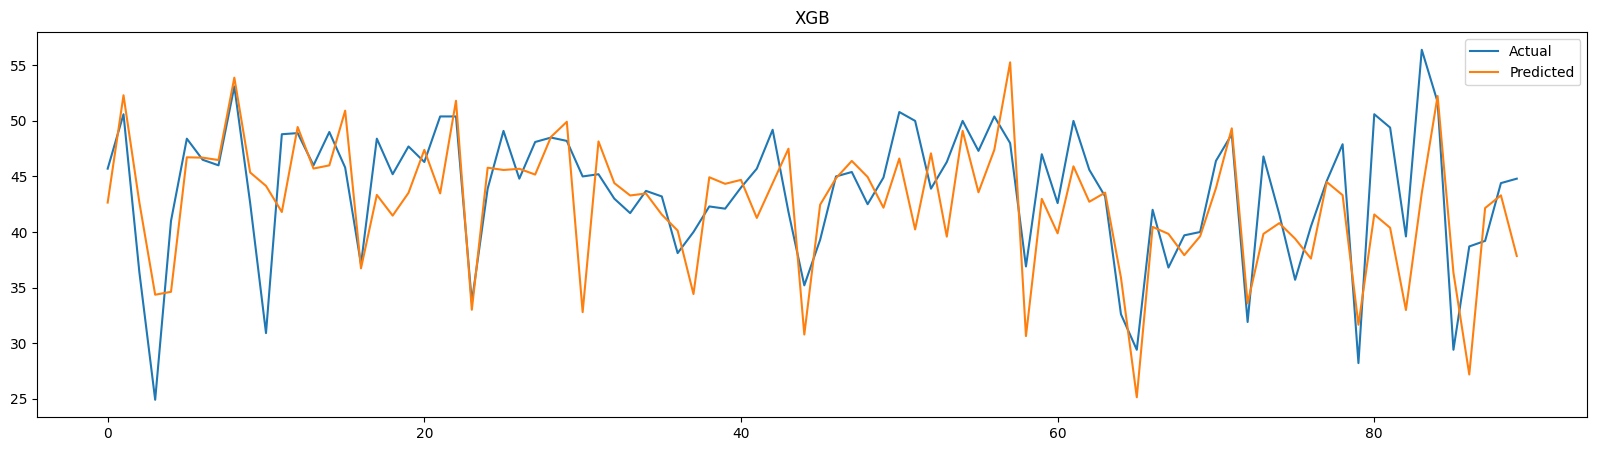

XGB   RMSE :  4.743309632878576
XGB   MAPE :  0.08681570402817268
XGB   MAE :  3.6289298756917314
Learning rate set to 0.048238
0:	learn: 0.3072824	total: 3.41ms	remaining: 3.4s
1:	learn: 0.2963946	total: 5.04ms	remaining: 2.51s
2:	learn: 0.2865014	total: 6.47ms	remaining: 2.15s
3:	learn: 0.2761098	total: 7.78ms	remaining: 1.94s
4:	learn: 0.2664545	total: 9.15ms	remaining: 1.82s
5:	learn: 0.2576555	total: 10.3ms	remaining: 1.71s
6:	learn: 0.2489916	total: 11.8ms	remaining: 1.67s
7:	learn: 0.2406668	total: 13.7ms	remaining: 1.7s
8:	learn: 0.2330875	total: 15.5ms	remaining: 1.71s
9:	learn: 0.2255903	total: 17.1ms	remaining: 1.69s
10:	learn: 0.2183178	total: 19.3ms	remaining: 1.73s
11:	learn: 0.2117782	total: 21ms	remaining: 1.73s
12:	learn: 0.2051960	total: 22.5ms	remaining: 1.71s
13:	learn: 0.1997405	total: 24.7ms	remaining: 1.74s
14:	learn: 0.1940442	total: 26ms	remaining: 1.71s
15:	learn: 0.1879965	total: 28.5ms	remaining: 1.75s
16:	learn: 0.1826461	total: 30.2ms	remaining: 1.74s
17:	

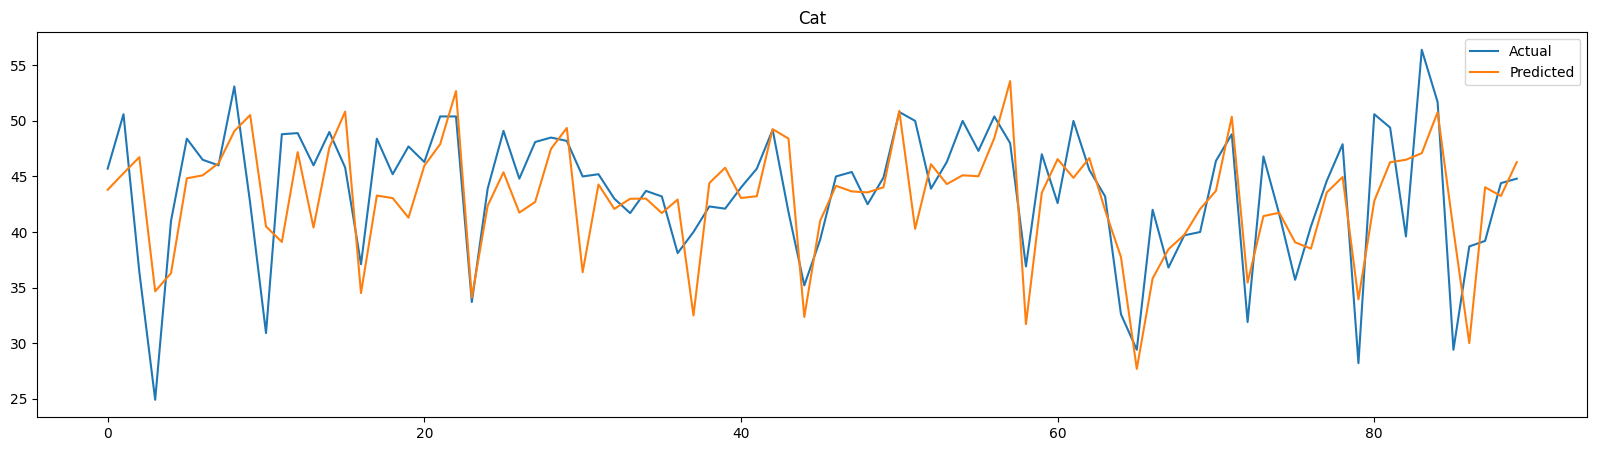

Cat   RMSE :  4.533563815582474
Cat   MAPE :  0.08623286133927127
Cat   MAE :  3.5564352720198906


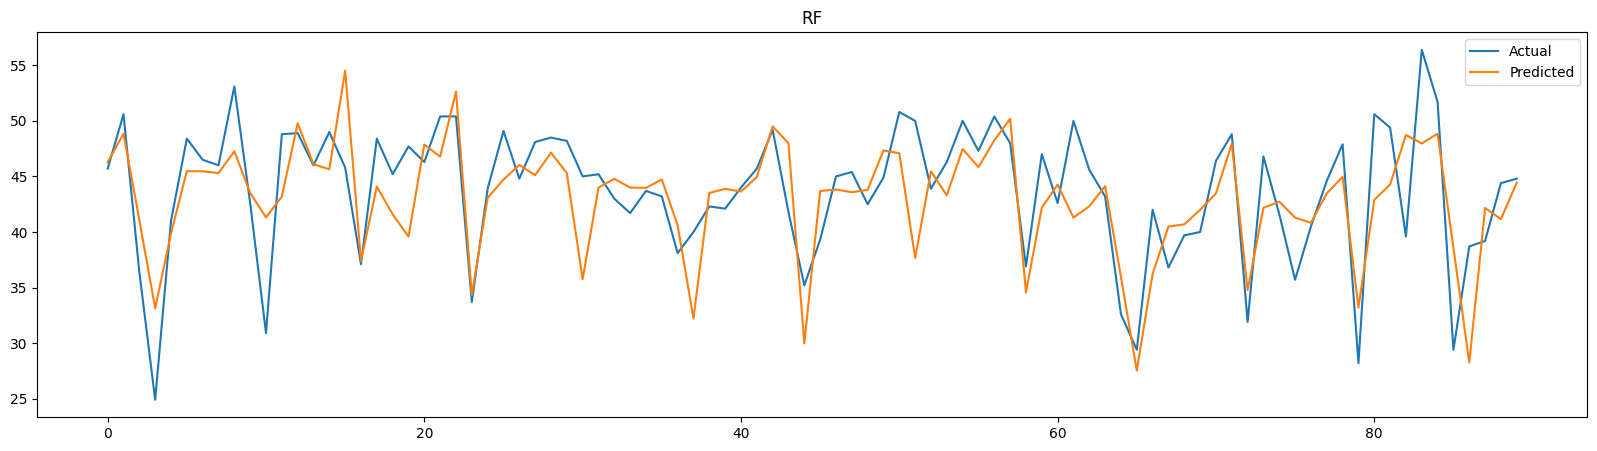

RF   RMSE :  4.399379968308666
RF   MAPE :  0.08093286315830633
RF   MAE :  3.3739333333333343


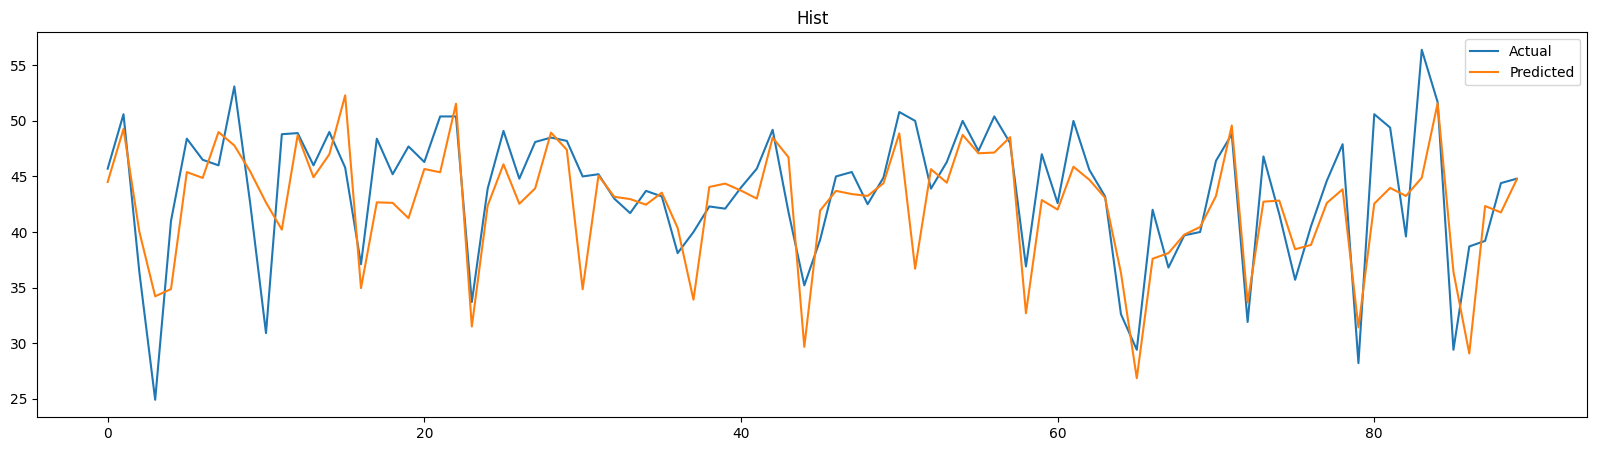

Hist   RMSE :  4.2278232314800235
Hist   MAPE :  0.07452462740983568
Hist   MAE :  3.1023497610268667


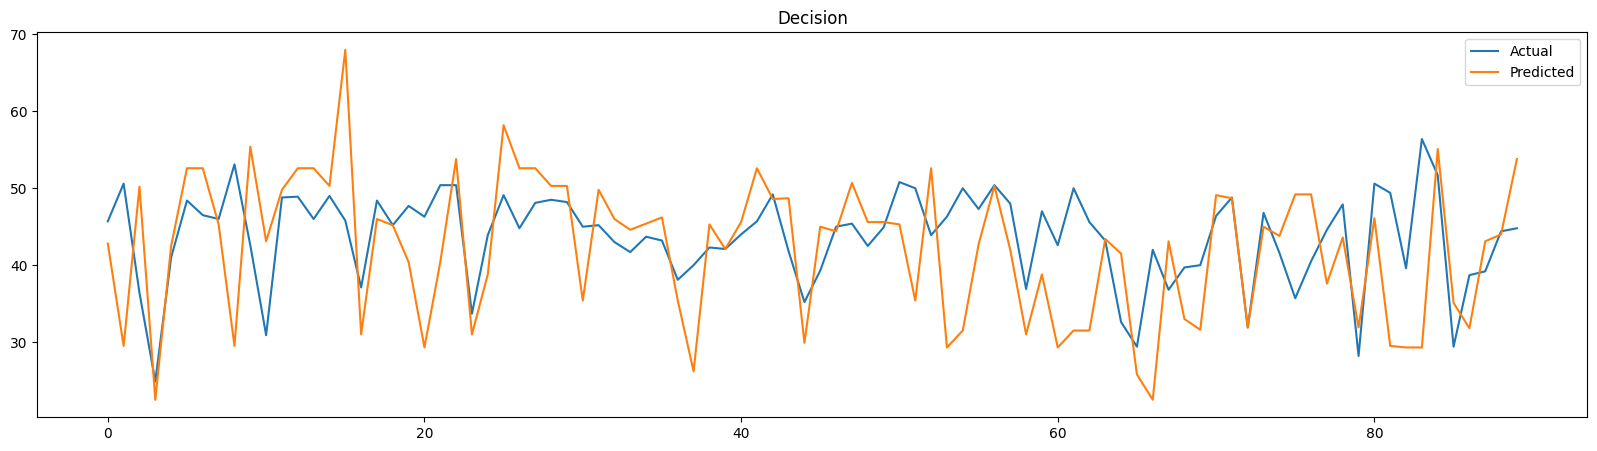

Decision   RMSE :  9.209011287260369
Decision   MAPE :  0.15752120125207358
Decision   MAE :  6.890000000000001


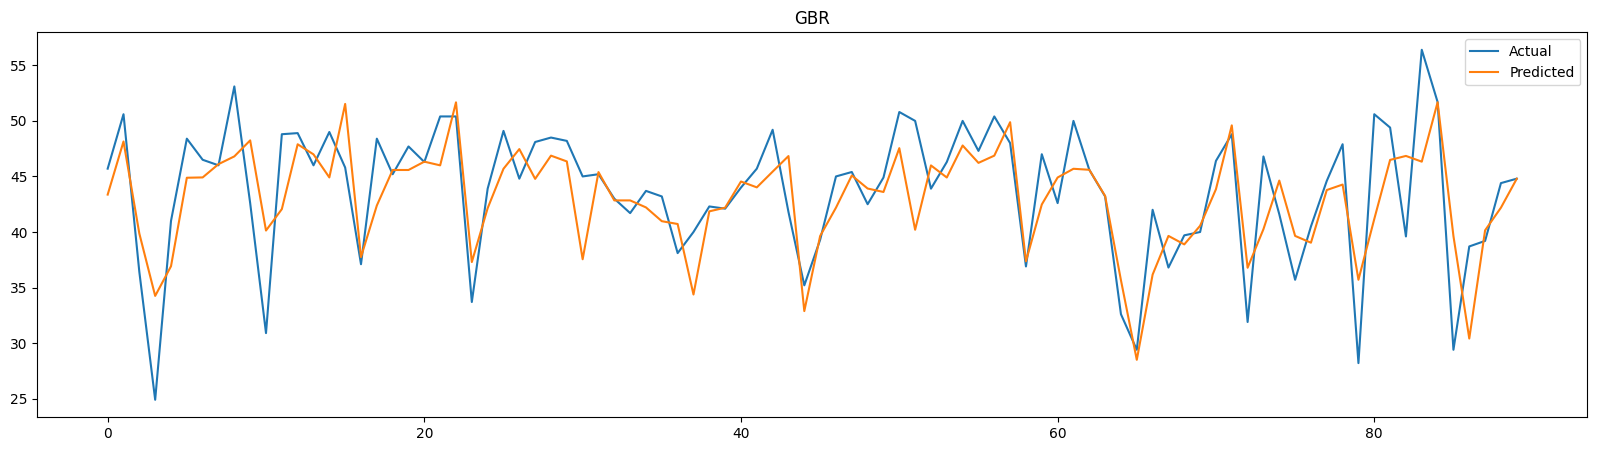

GBR   RMSE :  4.0919970418142775
GBR   MAPE :  0.0747703132434277
GBR   MAE :  3.0899487216913966


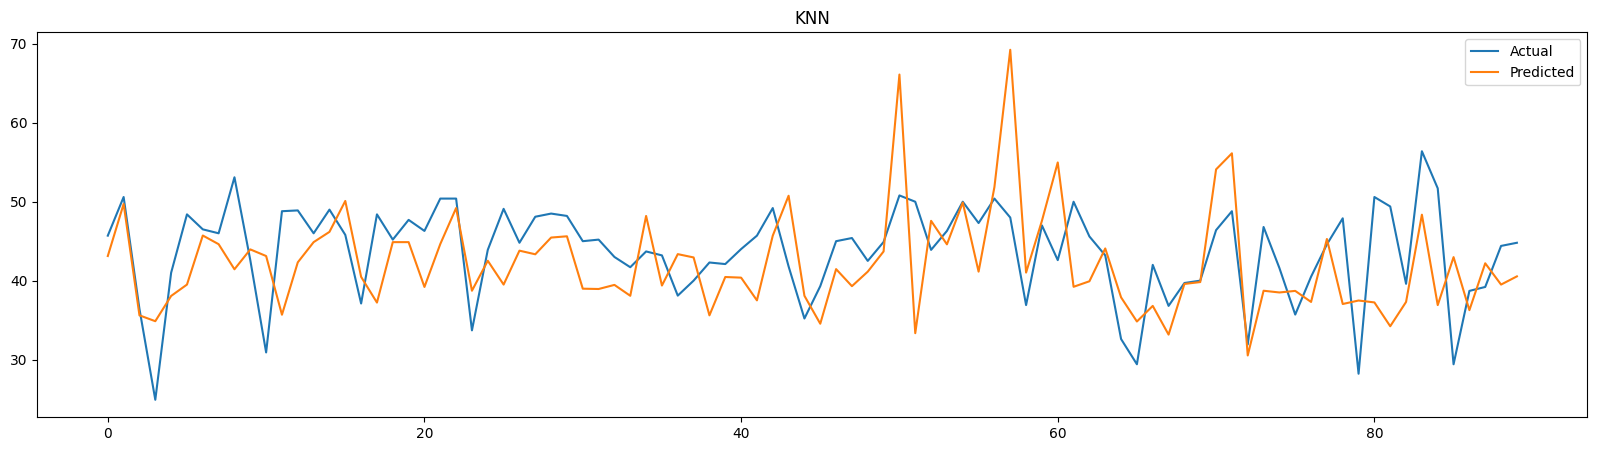

KNN   RMSE :  6.979494410214986
KNN   MAPE :  0.12553648475721563
KNN   MAE :  5.400444444444444


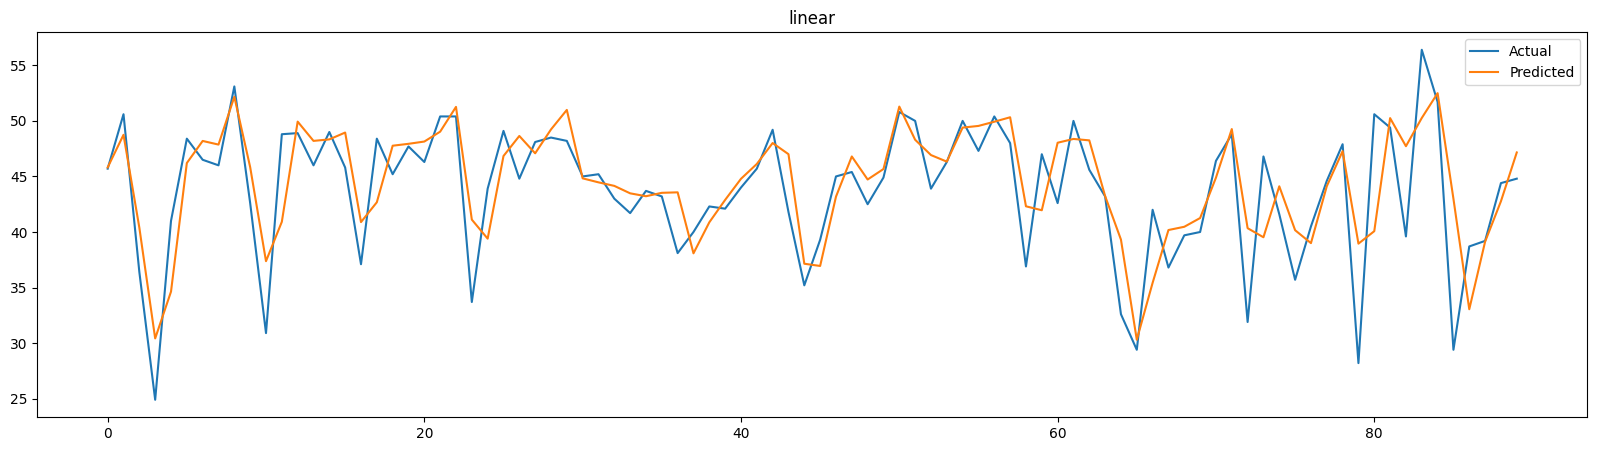

linear   RMSE :  3.9728798911775933
linear   MAPE :  0.07272769849800702
linear   MAE :  2.876990897356038


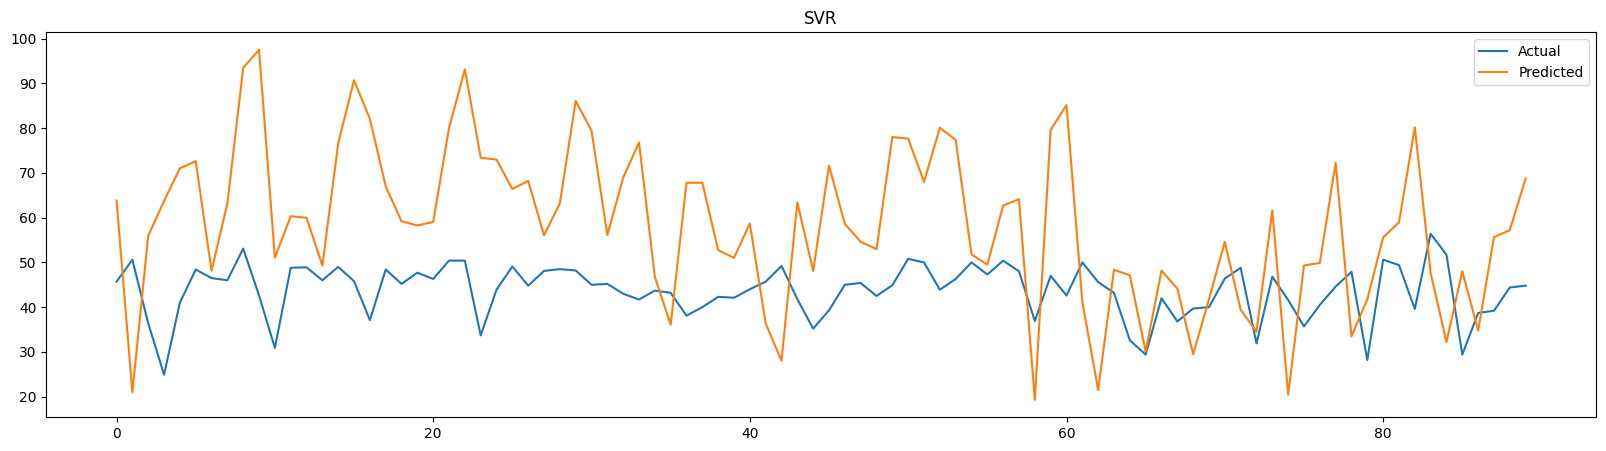

SVR   RMSE :  22.704912413776547
SVR   MAPE :  0.44849601481065754
SVR   MAE :  19.090354174024945


In [54]:
model_list = []
rmse_score = []
mape_score = []
mae_score = []

for key, values in models.items():
    nmodel = models[key]
    nmodel.fit(train_x, train_y)
    y_pred = nmodel.predict(test_x)
    plot_pred(test_y, y_pred, key)
    rmse = root_mean_squared_error(test_y, y_pred)
    mape = mean_absolute_percentage_error(test_y, y_pred)
    mae = mean_absolute_error(test_y, y_pred)
    model_list.append(key)
    rmse_score.append(rmse)
    mape_score.append(mape)
    mae_score.append(mae)
    print(key , "  RMSE : ", rmse)
    print(key , "  MAPE : ", mape)
    print(key , "  MAE : ", mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 2823, number of used features: 31
[LightGBM] [Info] Start training from score 3.661117


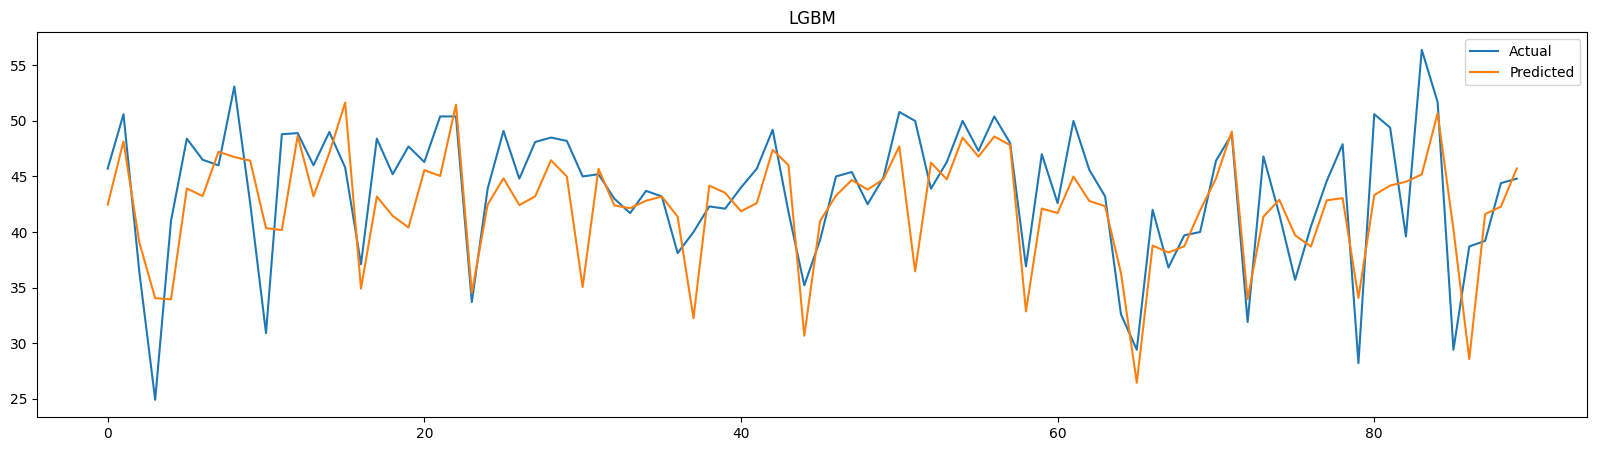

LGBM   RMSE :  4.460633747092279
LGBM   MAPE :  0.08193994268258938
LGBM   MAE :  3.416872989255585
[14:16:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "metric" } are not used.



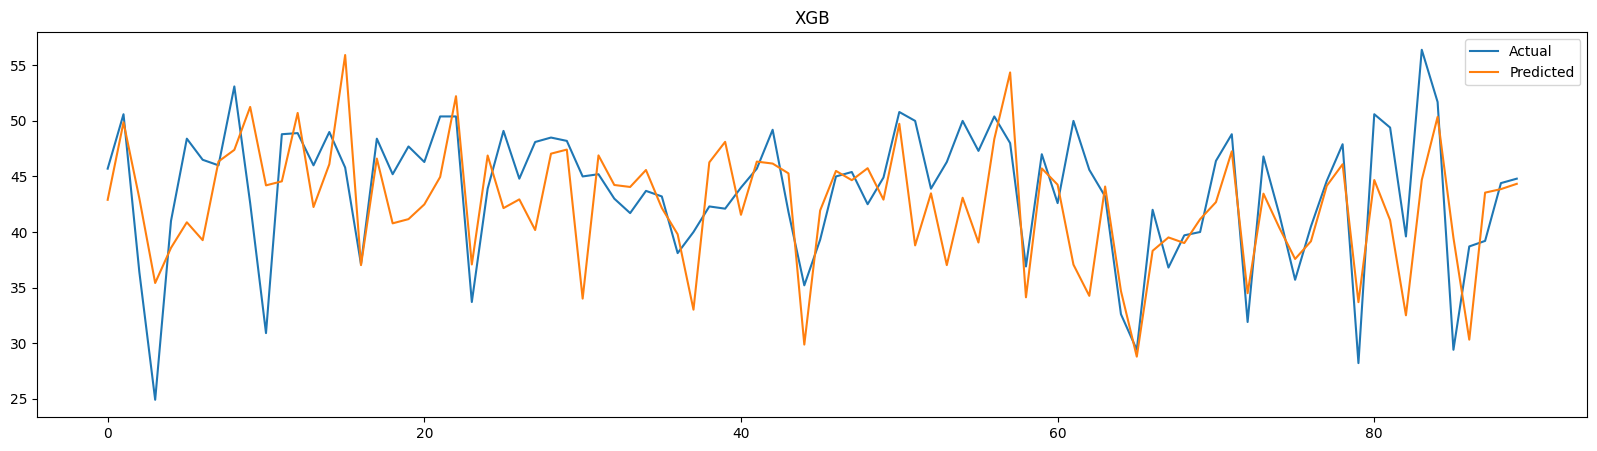

XGB   RMSE :  5.318816990848213
XGB   MAPE :  0.09704087743691758
XGB   MAE :  4.097374521891277
Learning rate set to 0.048238
0:	learn: 0.0741671	total: 2.32ms	remaining: 2.32s
1:	learn: 0.0714593	total: 3.64ms	remaining: 1.82s
2:	learn: 0.0690031	total: 4.74ms	remaining: 1.58s
3:	learn: 0.0665612	total: 6.08ms	remaining: 1.51s
4:	learn: 0.0641907	total: 7.28ms	remaining: 1.45s
5:	learn: 0.0619604	total: 9ms	remaining: 1.49s
6:	learn: 0.0599248	total: 10.4ms	remaining: 1.48s
7:	learn: 0.0580044	total: 12.7ms	remaining: 1.58s
8:	learn: 0.0561665	total: 14.3ms	remaining: 1.57s
9:	learn: 0.0544262	total: 16.4ms	remaining: 1.62s
10:	learn: 0.0527134	total: 17.9ms	remaining: 1.61s
11:	learn: 0.0510791	total: 19.6ms	remaining: 1.61s
12:	learn: 0.0495536	total: 21.3ms	remaining: 1.61s
13:	learn: 0.0481223	total: 22.6ms	remaining: 1.59s
14:	learn: 0.0467692	total: 24.6ms	remaining: 1.62s
15:	learn: 0.0453856	total: 26.8ms	remaining: 1.65s
16:	learn: 0.0441952	total: 28.4ms	remaining: 1.64s
17

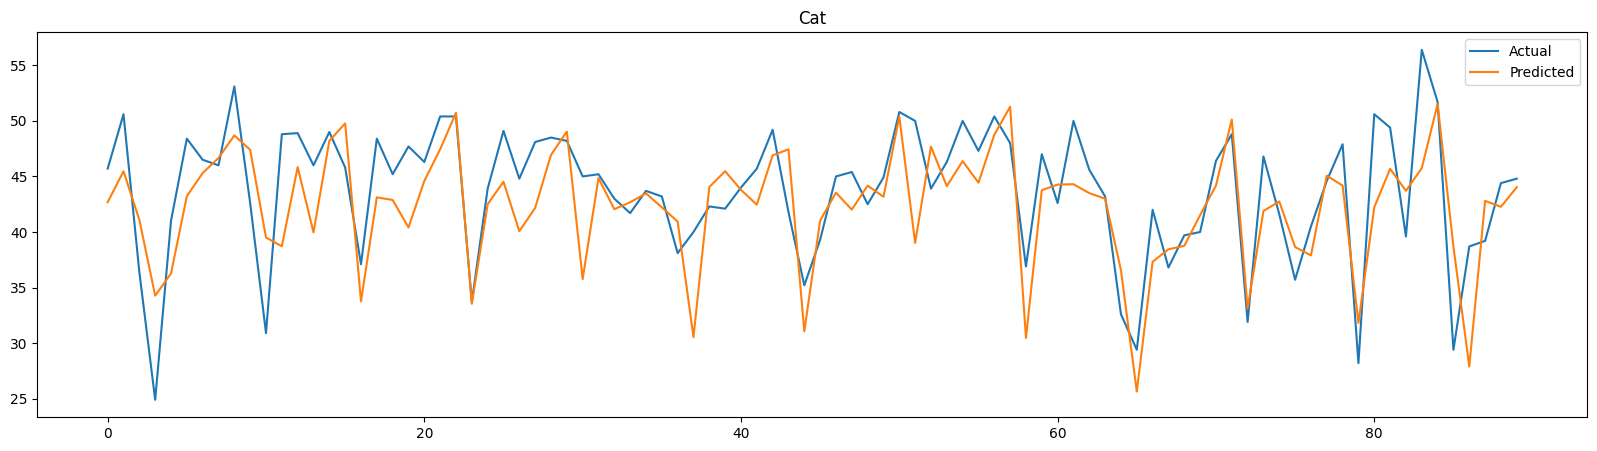

Cat   RMSE :  4.463004744760298
Cat   MAPE :  0.08395628001316376
Cat   MAE :  3.513526955769852


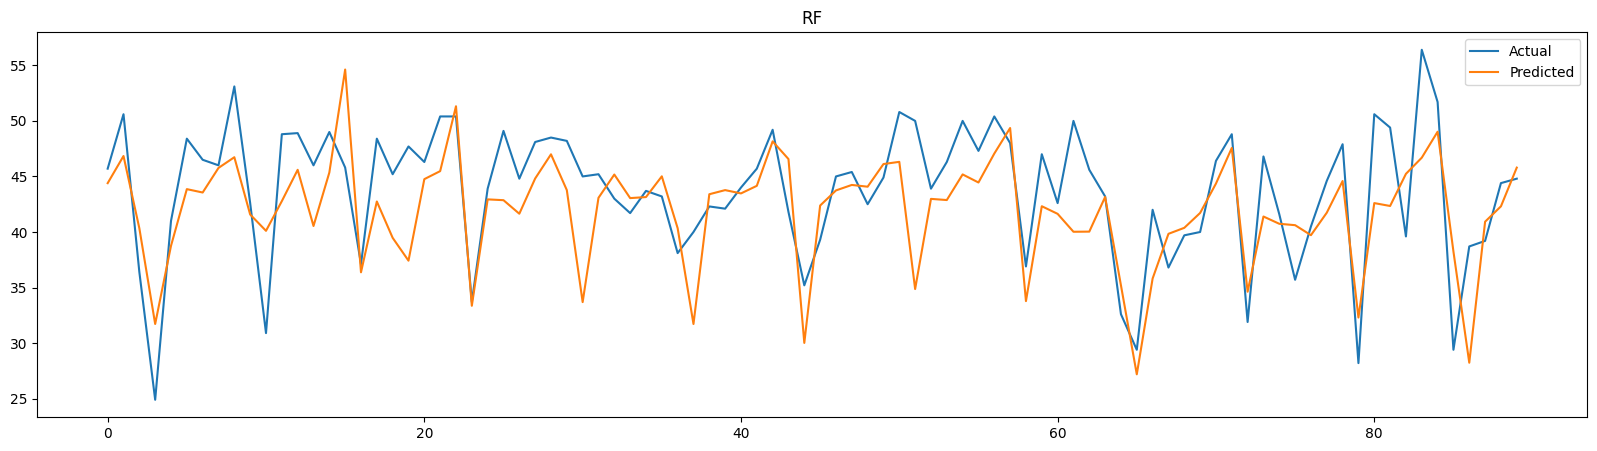

RF   RMSE :  4.779831879879236
RF   MAPE :  0.08722751813627183
RF   MAE :  3.73170877368037


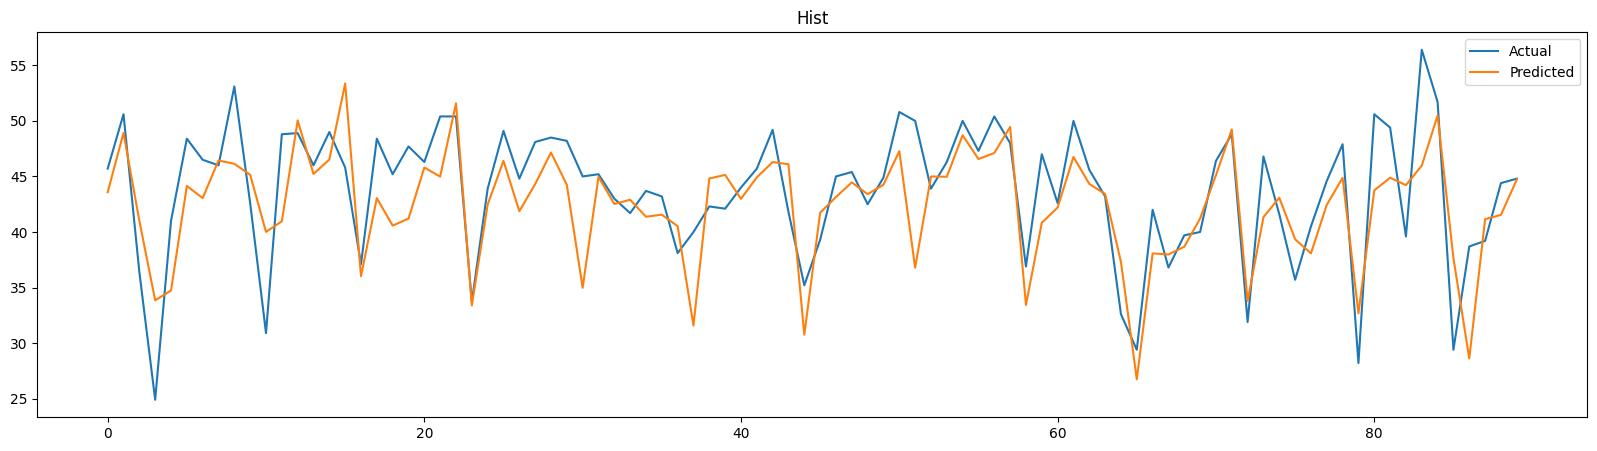

Hist   RMSE :  4.302533616887469
Hist   MAPE :  0.07862781471276062
Hist   MAE :  3.2921550100932406


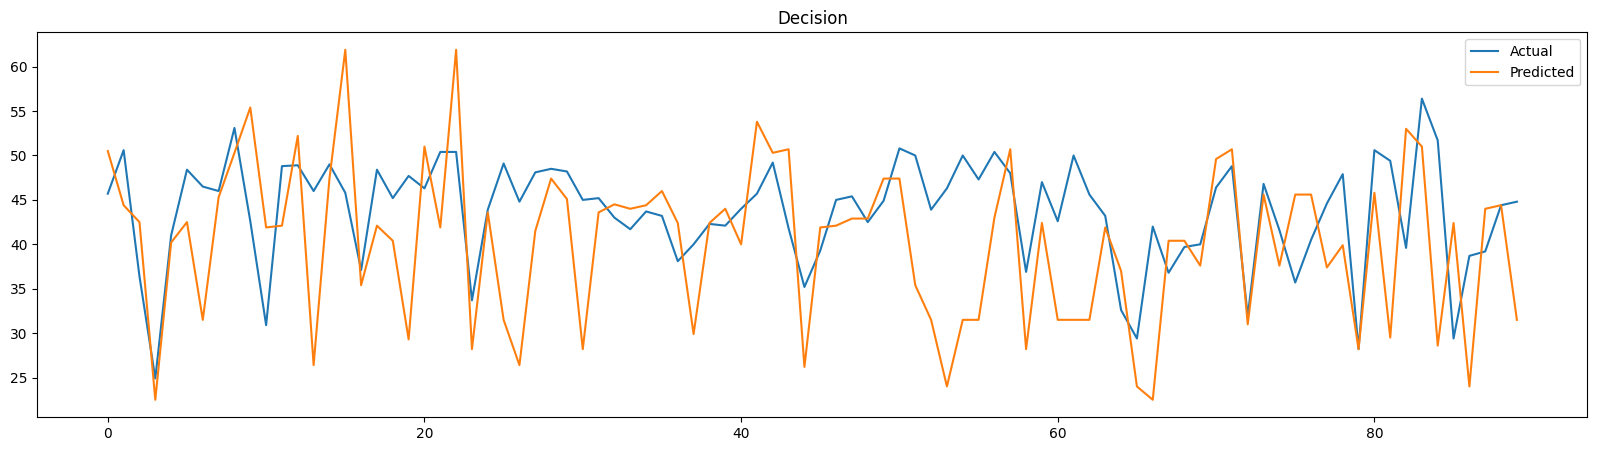

Decision   RMSE :  9.532459167380566
Decision   MAPE :  0.16587333115789168
Decision   MAE :  7.262222222222224


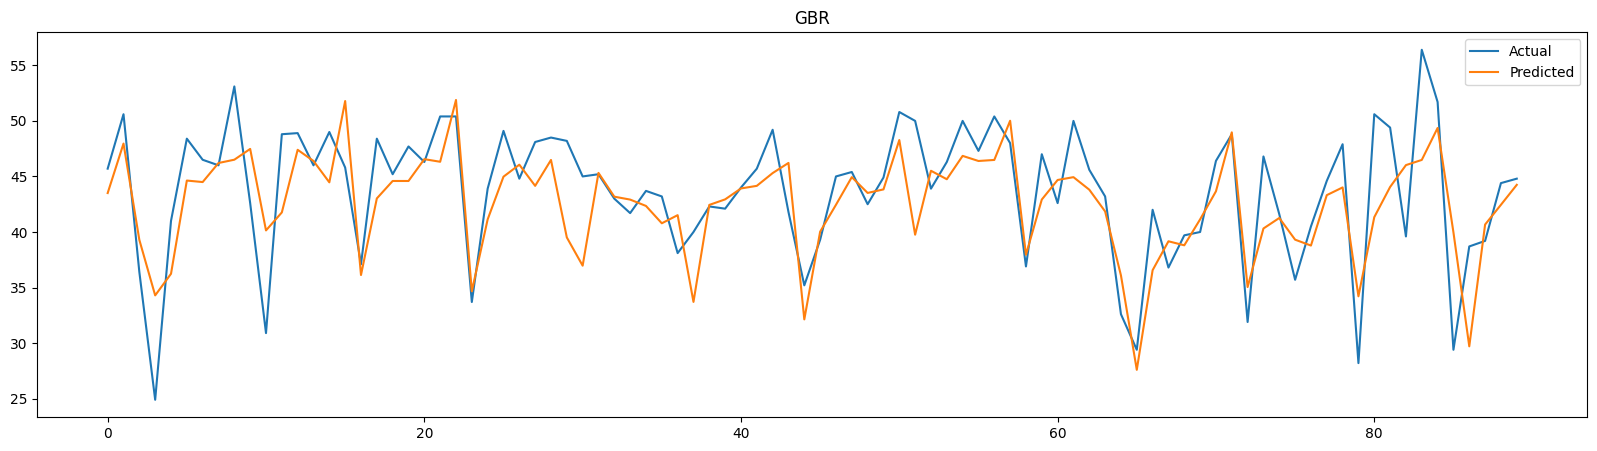

GBR   RMSE :  4.231446555515329
GBR   MAPE :  0.07782573687960254
GBR   MAE :  3.257303724768576


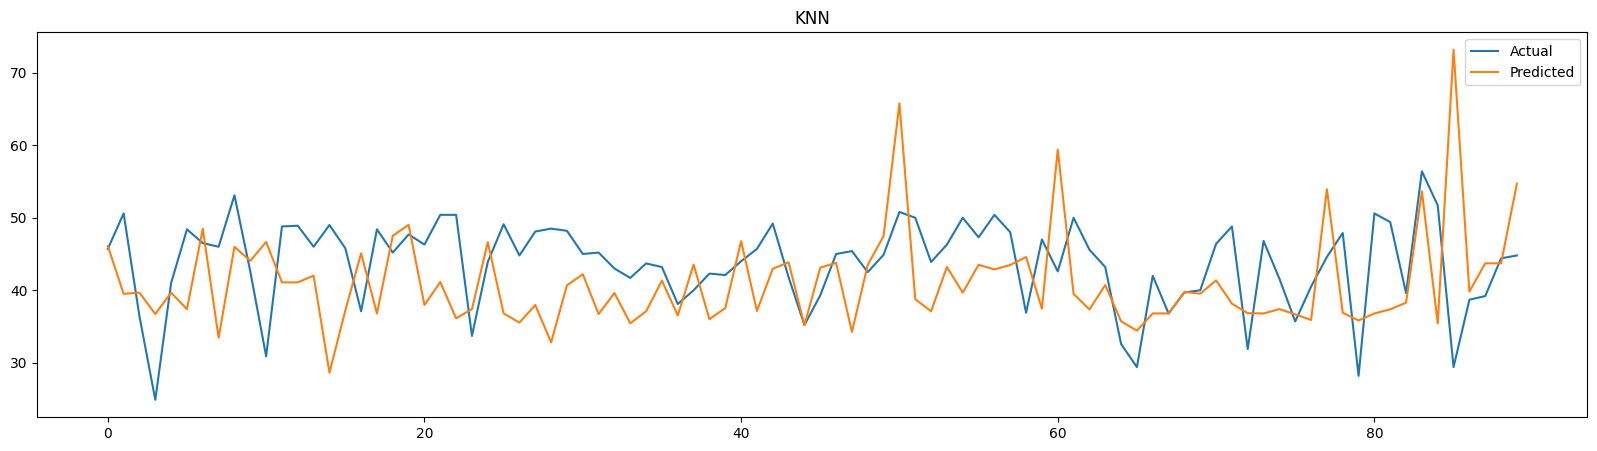

KNN   RMSE :  9.269451177279391
KNN   MAPE :  0.16498479637716285
KNN   MAE :  7.036903614287918


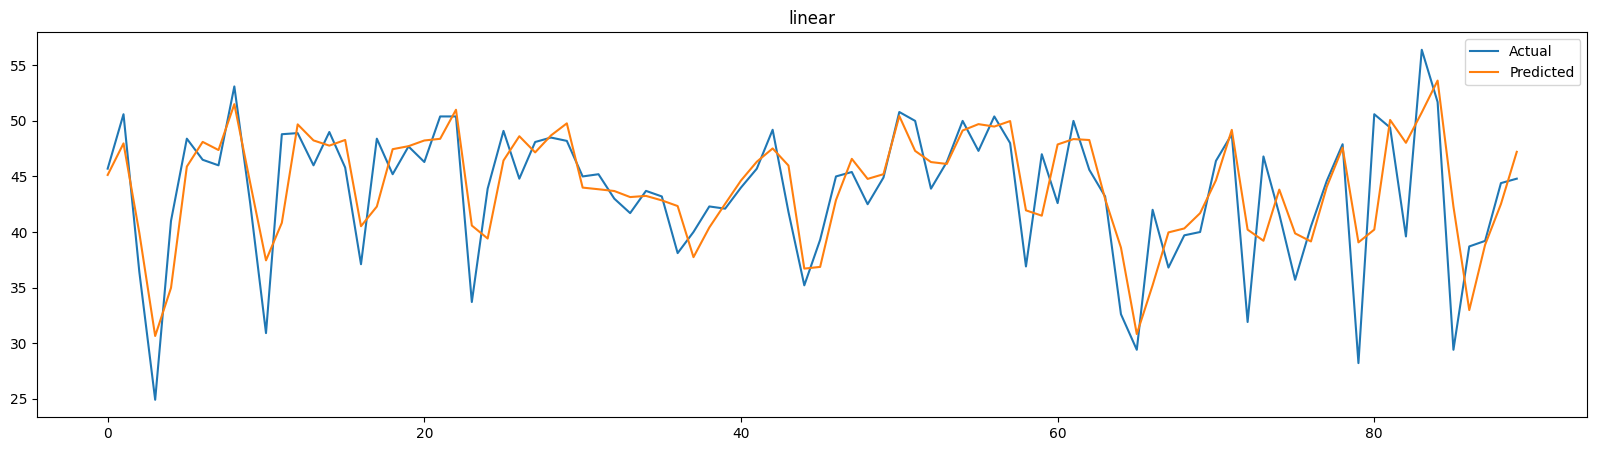

linear   RMSE :  3.893910866326086
linear   MAPE :  0.07170213151508553
linear   MAE :  2.848323288421718


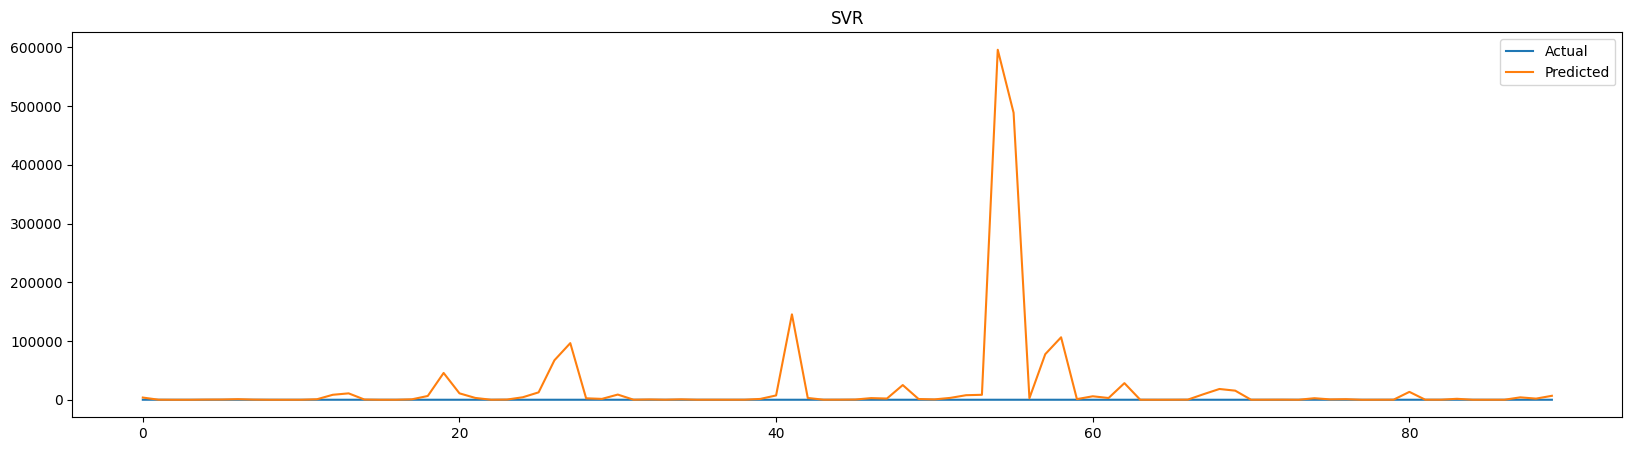

SVR   RMSE :  85097.19149670395
SVR   MAPE :  447.14953762346306
SVR   MAE :  20921.32317516844


In [51]:
log_model_list = []
log_rmse_score = []
log_mape_score = []
log_mae_score = []

for key, values in models.items():
    nmodel = models[key]
    nmodel.fit(log_train_x, log_train_y)
    log_y_pred = nmodel.predict(log_test_x)
    plot_pred(np.expm1(log_test_y), np.expm1(log_y_pred), key)
    rmse = root_mean_squared_error(np.expm1(log_test_y), np.expm1(log_y_pred))
    mape = mean_absolute_percentage_error(np.expm1(log_test_y), np.expm1(log_y_pred))
    mae = mean_absolute_error(np.expm1(log_test_y), np.expm1(log_y_pred))
    model_list.append(key)
    rmse_score.append(rmse)
    mape_score.append(mape)
    mae_score.append(mae)
    print(key , "  RMSE : ", rmse)
    print(key , "  MAPE : ", mape)
    print(key , "  MAE : ", mae)

In [44]:
result_df = pd.DataFrame({'Model': model_list, 'RMSE': rmse_score, 'MAPE':mape_score, 'MAE':mae_score}).reset_index(drop=True)
result_df

,Model,RMSE,MAPE,MAE
0,LGBM,4.445136,0.080546,3.360885
1,XGB,4.743310,0.086816,3.628930
2,Cat,4.533564,0.086233,3.556435
3,RF,4.146898,0.074111,3.068044
4,Hist,4.227823,0.074525,3.102350
5,Decision,9.209011,0.157521,6.890000
6,GBR,4.092175,0.074808,3.091343
7,KNN,6.979494,0.125536,5.400444
8,linear,3.972880,0.072728,2.876991
9,SVR,22.704912,0.448496,19.090354


In [52]:
log_result_df = pd.DataFrame({'Model': model_list, 'RMSE': rmse_score, 'MAPE':mape_score, 'MAE':mae_score}).reset_index(drop=True)
log_result_df

,Model,RMSE,MAPE,MAE
0,LGBM,4.460634,0.081940,3.416873
1,XGB,5.318817,0.097041,4.097375
2,Cat,4.463005,0.083956,3.513527
3,RF,4.779832,0.087228,3.731709
4,Hist,4.302534,0.078628,3.292155
5,Decision,9.532459,0.165873,7.262222
6,GBR,4.231447,0.077826,3.257304
7,KNN,9.269451,0.164985,7.036904
8,linear,3.893911,0.071702,2.848323
9,SVR,85097.191497,447.149538,20921.323175


In [ ]:
def plot_pred(y_test, y_pred, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

## 4. Hyperparameter Tuning

In [ ]:
model_hist = HistGradientBoostingRegressor()

# 파라미터 지정
  # max_depth: range(1, 21)
param = {
        'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
        'max_depth' : range(3,11),
        # 'max_iter' : range(100,1000,50)
        }

# 모델 선언
model = GridSearchCV(model_hist,  #기본 모델
                           param,     # 파라미터 범위
                           cv=5,      # k-fold 개수
                          )

model.fit(log_train_x, log_train_y)

print(model.cv_results_['mean_test_score'])
print('-'*80)
print(model.best_params_)
print('-'*80)
print(model.best_score_)

In [ ]:
log_y_pred = model.predict(log_test_x)
print(mean_squared_error(np.expm1(log_test_y), np.expm1(log_y_pred))**0.5)
print(mean_absolute_percentage_error(np.expm1(test_y), np.expm1(y_pred)))
print(mean_absolute_error(np.expm1(test_y), np.expm1(y_pred)))

In [ ]:
import xgboost 

model = xgboost.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    colsample_bytree=0.6,
    subsample=0.8
)